## **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import itertools

from gensim.utils import lemmatize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, confusion_matrix

In [ ]:
!pip install pattern

     |████████████████████████████████| 22.3MB 59.5MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 5.6MB 47.0MB/s 
     |████████████████████████████████| 5.5MB 39.6MB/s 
     |████████████████████████████████| 419kB 47.8MB/s 
     |████████████████████████████████| 3.2MB 42.7MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
  Created wheel for pattern: filename=Pattern-3.6-cp37-none-any.whl size=22332724 sha256=46a936f9655ea8299c3ba486a4473be4374d044ddb037ba1b42cacd9467f25f5
  Stored in directory: /root/.cache/pip/wheels/dc/9a/0e/5fb1a603ed4e3aa8722a88e9cf4a82da7d1b63e3d2cc34bee5
  Created wheel for mysqlclient: filename=mysqlclient-2.0.3-cp37-cp37m-linux_x86_64.whl size=100104 sha256=7b47405c8e3d411ca74f27575e77133cfb76869cec71172f89ce13016707f6ac
  Stored in directory: /root/.cache/pip/wheels/75/ca/e8/ad4e7ce3df18bcd91c7d84dd28c7c08db491a2a2360efed363
  Created whee

## **Loading the Dataset**
The original unstructured dataset(.txt file) was converted to structured format(.csv file) and is stored on google drive for easy access.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Corpus = pd.read_csv("drive/MyDrive/Dataset_Sentiment/amazon_reviews.csv",encoding='latin-1')

In [ ]:
Corpus.head(5)

,Review,Polarity
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [ ]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    1000 non-null   object
 1   Polarity  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


The amazon reviews dataset dosen't have any null values.

## **1. Data Pre-processing**
This step will help in getting better results through the classification algorithms

### **1.1 Should all Stop Words be eliminated?**

Traditional approaches employ the step of Stopword removal to get rid of the commonly occuring words which do not add any meaning to the sentence. This step might be quite tempting in order to get bettter results but also poses certain limitations for sentiment analysis tasks. 

At times, the prime sentiment of the review is completely altered after removing stopwords as is shown in the example below:

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
Corpus['Review'][41]

'I was not impressed by this product.'

Originally, the review has a negative conotation.

In [ ]:
text = "I was not impressed by this product."
remove_stopwords(text)

'I impressed product.'

After stopword removal the word "not" which conveys negative sentiment is eliminated. The resultant review seems to be positive.

In [ ]:
lemmatize(Corpus['Review'][41])

[b'be/VB', b'not/RB', b'impress/VB', b'product/NN']

Whereas, the lemmatize function of gensim preferentially selects only adjectives(RR), adverbs(RB), verbs(VB) and nouns(NN) and discards all the other words. Using this functionality we are able to achieve a dual objective:
1. Retain all the keywords which convey the prime sentiment of a given review
2. Get rid of all the other words without explicitly eliminating the stopwords

### **1.2 Covert the text to lower case**

This is required as python interprets 'text', 'Text' and 'TEXT' differently.

In [ ]:
Corpus['Review'] = [text.lower() for text in Corpus['Review']]

In [ ]:
Corpus['Review'].head()

0    so there is no way for me to plug it in here i...
1                          good case, excellent value.
2                               great for the jawbone.
3    tied to charger for conversations lasting more...
4                                    the mic is great.
Name: Review, dtype: object

### **1.3 Text Lemmatization**

In [ ]:
for index,text in enumerate(Corpus['Review']):
  
    words = [word.decode('utf-8').split('/')[0] for word in lemmatize(text)]
    
    Corpus.loc[index,'text_final'] = str(words)

In [ ]:
Corpus['text_final'].head()

0     ['be', 'way', 'plug', 'here', 'go', 'converter']
1               ['good', 'case', 'excellent', 'value']
2                                 ['great', 'jawbone']
3    ['tie', 'charger', 'conversation', 'last', 'mo...
4                               ['mic', 'be', 'great']
Name: text_final, dtype: object

## **2. Split the model into Train and Test Data set**

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['Polarity'],test_size=0.2, random_state = 123)

## **3. Vectorize the words by using TF-IDF Vectorizer** 
This is done to find how important a word in document is in comaprison to the corpus

In [ ]:
Tfidf_vect = TfidfVectorizer(decode_error='ignore')
Tfidf_vect.fit(Train_X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
Train_X_Tfidf

<800x1242 sparse matrix of type '<class 'numpy.float64'>'
	with 4824 stored elements in Compressed Sparse Row format>

The tfidf sparse matrix is stored in .csv file to study how each word is scored in a review as well as view the generated dictionary of 1242 words. 

In [ ]:
feature_names = Tfidf_vect.get_feature_names()
corpus_index = [n for n in Train_X_Tfidf]

df = pd.DataFrame(Train_X_Tfidf.T.todense(), index=feature_names, columns=corpus_index)

In [ ]:
df.to_csv("review_vectors.csv")

## **4. Review Classification Algorithms**
In this step we will run different algorithms to classify the given data and evaluate on various metrics like AUC score, accuracy, precision, recall and F1 Score.

### **4.1 Naive Bayes**

In [ ]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
         }

In [ ]:
naive_GS = GridSearchCV(naive_bayes.MultinomialNB(), param_grid=params, n_jobs=-1, cv=10, verbose=3)
naive_GS.fit(Train_X_Tfidf,Train_Y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
naive_GS.best_params_

{'alpha': 1.0}

In [ ]:
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB(alpha=1.0)
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# predict the labels on test dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

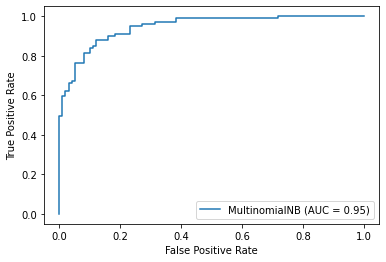

In [ ]:
plot_roc_curve(Naive, Test_X_Tfidf, Test_Y) 

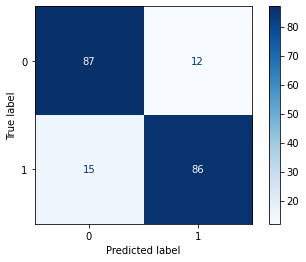

In [ ]:
plot_confusion_matrix(Naive, Test_X_Tfidf, Test_Y, cmap='Blues') 

plot_confusion_matrix() an inbuilt function can be used to view the confusion matrix directly. For our project, we define the function separately in order to customize the output matrix to get a clear view of label values.

In [ ]:
cm = confusion_matrix(y_true= Test_Y, y_pred=predictions_NB)
plot_labels = [0,1]

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize= 'xx-large',
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

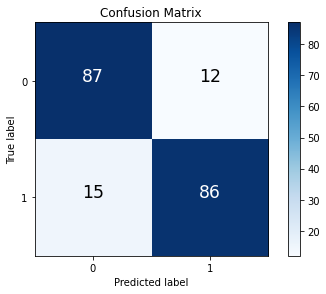

In [ ]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='Confusion Matrix')

In [ ]:
print("Accuracy  ->  {:.3f}".format(accuracy_score(predictions_NB, Test_Y)),
      "\nPrecision ->  {:.3f}".format(precision_score(predictions_NB, Test_Y)),
      "\nRecall    ->  {:.3f}".format(recall_score(predictions_NB, Test_Y)),
      "\nF1-Score  ->  {:.3f}".format(f1_score(predictions_NB, Test_Y)))

Accuracy  ->  0.865 
Precision ->  0.851 
Recall    ->  0.878 
F1-Score  ->  0.864


### **4.2 SVM**

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 

In [ ]:
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1, cv=10)
grid.fit(Train_X_Tfidf,Train_Y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   25.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [ ]:
print(grid.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
SVM = svm.SVC(C=100, gamma=.01, kernel='rbf')

In [ ]:
# fitting training data on the classifier
SVM.fit(Train_X_Tfidf,Train_Y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# predicting labels on test dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

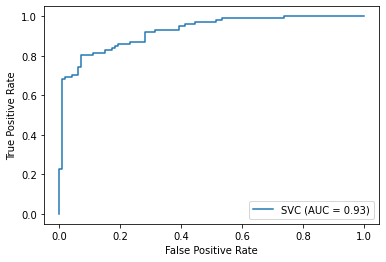

In [ ]:
plot_roc_curve(SVM, Test_X_Tfidf, Test_Y)

In [ ]:
cm = confusion_matrix(y_true= Test_Y, y_pred=predictions_SVM)
plot_labels = [0,1]

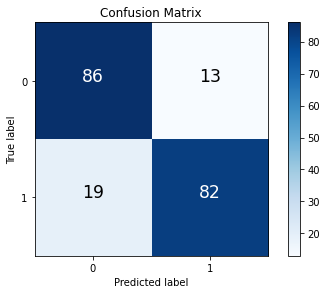

In [ ]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='Confusion Matrix')

In [ ]:
print("Accuracy  ->  {:.3f}".format(accuracy_score(predictions_SVM, Test_Y)),
      "\nPrecision ->  {:.3f}".format(precision_score(predictions_SVM, Test_Y)),
      "\nRecall    ->  {:.3f}".format(recall_score(predictions_SVM, Test_Y)),
      "\nF1-Score  ->  {:.3f}".format(f1_score(predictions_SVM, Test_Y)))

Accuracy  ->  0.840 
Precision ->  0.812 
Recall    ->  0.863 
F1-Score  ->  0.837
